<a href="https://colab.research.google.com/github/ucheokechukwu/NLP-Project/blob/master/mini_project_V.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Identifying Duplicate Questions

Over 100 million people visit Quora every month, so it's no surprise that many people ask similar (or the same) questions. Various questions with the same intent can cause people to spend extra time searching for the best answer to their question, and results in members answering multiple versions of the same question. Quora uses random forest to identify duplicated questions to provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
Follow the steps outlined below to build the appropriate classifier model. 


Steps:
- Download data
- Exploration
- Cleaning
- Feature Engineering
- Modeling

By the end of this project you should have **a presentation that describes the model you built** and its **performance**. 


Different Models:
1. 'old school' with elaborate feature geneation (word count, common words, etc)/ tfidf tokenization and Naive Bayes (grid search)
2. Deep learning with LSTM and embedding - 2 types of layering
3. deep learning with keras sentence encoder - just modify the output layer

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None) # to display full text without truncations

In [3]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-2758d295-b43e-96ef-3d28-da75297c2913)


In [4]:
df = pd.read_csv("data/train.csv")

#### Note
There is no designated test.csv file. The train.csv file is the entire dataset. Part of the data in the train.csv file should be set aside to act as the final testing data.

In [5]:
# quick data overview
display(df.info())
display(df.describe())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


None

,id,qid1,qid2,is_duplicate
count,404290.000000,404290.000000,404290.000000,404290.000000
mean,202144.500000,217243.942418,220955.655337,0.369198
std,116708.614503,157751.700002,159903.182629,0.482588
min,0.000000,1.000000,2.000000,0.000000
25%,101072.250000,74437.500000,74727.000000,0.000000
50%,202144.500000,192182.000000,197052.000000,0.000000
75%,303216.750000,346573.500000,354692.500000,1.000000
max,404289.000000,537932.000000,537933.000000,1.000000


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in share market in india?,What is the step by step guide to invest in share market?,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Diamond?,What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?,0
2,2,5,6,How can I increase the speed of my internet connection while using a VPN?,How can Internet speed be increased by hacking through DNS?,0
3,3,7,8,Why am I mentally very lonely? How can I solve it?,"Find the remainder when [math]23^{24}[/math] is divided by 24,23?",0
4,4,9,10,"Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?",Which fish would survive in salt water?,0


### Exploration

**Checking for Null and Duplicates**. Via `info()`, already identified 3 NULL fields. Will delete them as they fractional compared to the entire dataset.

In [6]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 404287 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404287 non-null  int64 
 1   qid1          404287 non-null  int64 
 2   qid2          404287 non-null  int64 
 3   question1     404287 non-null  object
 4   question2     404287 non-null  object
 5   is_duplicate  404287 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 21.6+ MB


In [7]:
# checking for duplicates 
df.duplicated().sum()

0

In [8]:
df[df['is_duplicate']==1].sample(n=5)
df[df['is_duplicate']==0].sample(n=5)

,id,qid1,qid2,question1,question2,is_duplicate
233662,233662,343960,343961,Why is rabbit meat considered to be white meat?,"What meats are considered ""white meat""?",0
237256,237256,348384,348385,What psychological & physical changes occur when a male is deprived of sexual intercourse in his prime?,What is 1 plus 1?,0
217630,217630,3505,324042,"Instagram (product): How can I login to Instagram if I don't remember the password, and I dont know the email address that was used to set up the account?",What do you do if you don't know your Gmail and password to your Instagram?,0
369145,369145,156195,499550,How did you pick your profile picture? What makes a good one?,How can I make my profile picture not awkward?,0
193886,193886,293935,293936,Can I have a pet sloth in Ohio?,How many toes does a sloth have?,0


#### Creating test_df to hold out as separately

In [9]:
test_df = df.sample(frac=0.2)

filter = df.index.isin(test_df.index.tolist())
train_df = df[~filter]

# checking for intersection
set (train_df.index) & set(test_df.index) # should be empty to pass

set()

### Cleaning

- Tokenization
- Stopwords cleaning
- Removing punctuation
- Normalizing
- Stemming

In [10]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [11]:
import string

from nltk.corpus import stopwords
stopwords_eng = stopwords.words('english')

from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize # to get other parts of speach

import spacy
nlp = spacy.load("en_core_web_sm")

In [12]:
len(train_df)

323430

In [61]:
# sample text for testing
text = train_df['question1'][:1]
text

1    What is the story of Kohinoor (Koh-i-Noor) Diamond?
Name: question1, dtype: object

In [62]:
def preprocessing (documents):
    cleaned_documents = []
    for text in documents:

        # lower case
        text = text.lower()
        # stopwords clearning
        stopwords = stopwords_eng
        text = " ".join([word for word in text.split() if word not in stopwords_eng])

        # removing punctuation
        punctuation = string.punctuation
        text = "".join([char for char in list(text) if char not in string.punctuation])

        # normalizing
        text = nlp(text)

        # lemming & tokenize
        text = [token.lemma_ for token in text]

        
        cleaned_documents.append(text)
    
    return cleaned_documents
    

    
preprocessing(text)

[['story', 'kohinoor', 'kohinoor', 'diamond']]

### Feature Engineering

- tf-idf
- word2vec
- word count
- number of the same words in both questions
- ....

# Using Gensim `Doc2Vec`

In [22]:
## Building the Corpus

# let's use a sample of the data

preprocessed_train_q1 = preprocessing(train_df['question1'])
preprocessed_train_q2 = preprocessing(train_df['question2'])


In [23]:
import gensim
training_texts = preprocessed_train_q1 + preprocessed_train_q2
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
train_corpus = [TaggedDocument(doc, [i]) for i, doc in enumerate(training_texts)]

### Training the model

In [24]:
import matplotlib.pyplot as plt

(array([3.86092e+05, 2.08353e+05, 4.50280e+04, 5.57000e+03, 1.36400e+03,
        3.30000e+02, 7.70000e+01, 1.90000e+01, 4.00000e+00, 2.00000e+00,
        4.00000e+00, 3.00000e+00, 1.00000e+00, 1.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.20000e+01]),
 array([  0. ,   5.5,  11. ,  16.5,  22. ,  27.5,  33. ,  38.5,  44. ,
         49.5,  55. ,  60.5,  66. ,  71.5,  77. ,  82.5,  88. ,  93.5,
         99. , 104.5, 110. ]),
 <BarContainer object of 20 artists>)

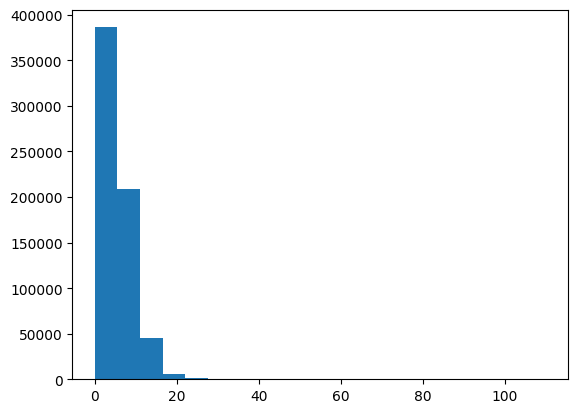

In [26]:
length_of_text = []
for text in (preprocessed_train_q1 + preprocessed_train_q2):
  length_of_text.append(len(text))

plt.hist(length_of_text, bins=20)


In [27]:

# instantiate the model
model = Doc2Vec(vector_size=30, min_count=2, epochs=40)
# build a vocabulary
model.build_vocab(train_corpus)
# train the model on the corpus
model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)




In [43]:
model.save("model/d2v.model")
model_ = Doc2Vec.load("model/d2v.model")
model_

### Assessing the model

In [67]:
# assess the model on the training data i.e. do a self-similarity check
def doc2vectorization(train):
  vectors = []
  sentences = train.copy()
  for sentence in sentences:
    vector = model_.infer_vector(sentence)
    vectors.append(vector)
  return vectors

In [68]:
q1vector = doc2vectorization(preprocessed_train_q1)
q2vector = doc2vectorization(preprocessed_train_q2)

In [69]:
# saving documents

pd.DataFrame(preprocessed_train_q1).to_csv('output/preprocessed_train_1.csv', 
                                           index=False, header=False)
pd.DataFrame(preprocessed_train_q2).to_csv('output/preprocessed_train_2.csv', 
                                           index=False, header=False)

In [76]:
pd.DataFrame(q1vector).to_csv('output/q1vector.csv', 
                                           index=False, header=False)
pd.DataFrame(q2vector).to_csv('output/q2vector.csv', 
                                           index=False, header=False)

# SYSTEM CRASH 
**continue from here** 
At this point my system crashed because it had used up all the RAM. But that's OK because I had thoughtfully saved everything important before then.

In [1]:
import pandas as pd
q1vector = pd.read_csv('output/q1vector.csv')
q2vector = pd.read_csv('output/q2vector.csv')


In [2]:
import numpy as np

q1vector_n = np.array(q1vector)
q2vector_n = np.array(q2vector)
q1vector_n.shape, q2vector_n.shape

((323429, 30), (323429, 30))

In [4]:
q1vector_n[:10].shape

(10, 30)

In [24]:
# get cosine similarity 
from sklearn.metrics.pairwise import cosine_similarity
# cos_q1q2 = [cosine_similarity(q1, q2) for q1, q2 in zip (q1vector, q2vector)]

cosine_similarity(q1vector_n[0:1], q2vector_n[0:1])


array([[0.46240706]])

In [38]:
cos_q1q2 = [cosine_similarity(q1vector_n[i:i+1], q2vector_n[i:i+1]) for i in range(323428)]

In [53]:
cos_q1q2 = np.squeeze(np.array(cos_q1q2))
pd.DataFrame(cos_q1q2).to_csv('output/cos_q1q2.csv', 
                                           index=False, header=False)

### Modeling

Different modeling techniques can be used:

- logistic regression
- XGBoost
- LSTMs
- etc